In [1]:
import sys

sys.path.append('../poligrain/src')
sys.path.append('../mergeplg/src')

import poligrain as plg
import mergeplg as mrg

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Create synthetic example data

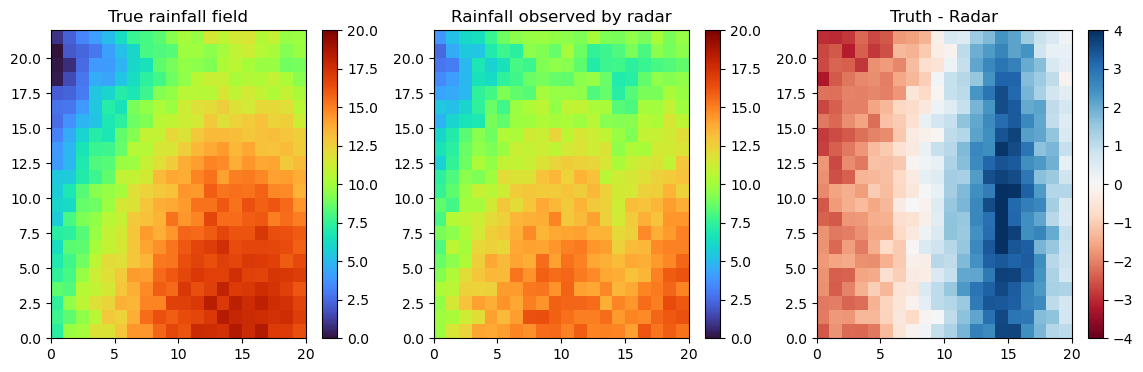

In [2]:
# grid axes
x = np.arange(0, 20)
y = np.arange(20, 42)
x_grid, y_grid = np.meshgrid(x, y)

np.random.seed(13196840)

# Synthetic true rainfall
truth = (
    np.abs(10.0 * np.sin(0.11 * x_grid))
    + np.abs(8.0 * np.sin(0.08 * y_grid))
    )
truth = truth + 0.8 * np.random.uniform(low=-1.0, high=1, size=x_grid.shape)

# Creating radar data by perturbing truth
radar = truth.copy()
radar = 1.0 * truth + 0.5 * np.random.uniform(low=-1.0, high=1, size=x_grid.shape)
radar = (
    radar 
    + np.abs(6 * np.cos(0.11 * x_grid))
    - np.abs(3 * np.sin(0.06  * y_grid))
)
radar = radar - 1
radar[radar < 0.0] = 0.0


vmin, vmax = 0, 20
cmap = 'turbo'
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].set_title('True rainfall field')
pc = axs[0].pcolormesh(truth, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(pc)
axs[1].set_title('Rainfall observed by radar')
pc = axs[1].pcolormesh(radar, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(pc)
axs[2].set_title('Truth - Radar')
pc = axs[2].pcolormesh(truth - radar, vmin=vmax * -0.2, vmax=vmax * 0.2, cmap='RdBu')
plt.colorbar(pc);



In [3]:
ds_radar = xr.Dataset(
    data_vars={
        'R_observed': ( ['y', 'x'], radar),
        'R_true': (['y',  'x'], truth),
    },
    coords={
        'x_grid': (['y', 'x'], x_grid),
        'y_grid':  (['y',   'x'], y_grid),
    },
)


## Radar-gauge adjustment

### Create synthetic gauge observations

In [4]:
ds_gauges = xr.Dataset(
    data_vars={
        'R_init': (['id'], [0, 0, 0, 0]),
    },
    coords={
        'x': (('id'), [2, 16, 3, 6]),
        'y':  (['id'], [22, 25, 33, 26]),
        'lon': (('id'), [2, 16, 3, 6]),
        'lat':  (['id'], [22, 25, 33, 26]),
    },
)

In [5]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar,
    da_point_data=ds_gauges,
    nnear=1,
    use_lon_lat=False,
)

ds_gauges['R'] = get_grid_at_points(
    da_gridded_data=ds_radar.R_true,
    da_point_data=ds_gauges.R_init,
)

<Axes: xlabel='x_grid', ylabel='y_grid'>

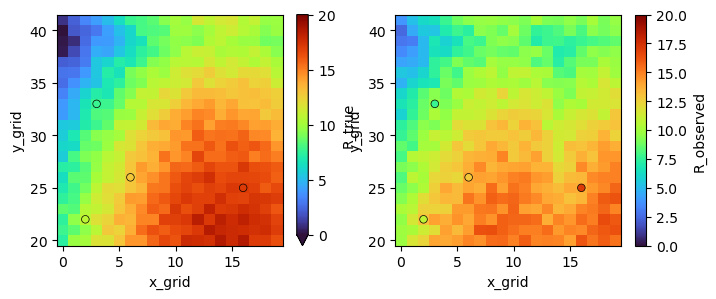

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)

### Additive adjustment with IDW interpolation

#### Calculate differencence between gauge data and radar data at gauge location

In [7]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar,
    da_point_data=ds_gauges,
    nnear=1,
    use_lon_lat=False,
)

ds_gauges['R_radar'] = get_grid_at_points(
    da_gridded_data=ds_radar.R_observed,
    da_point_data=ds_gauges.R,
)

ds_gauges['R_diff'] = ds_gauges.R - ds_gauges.R_radar

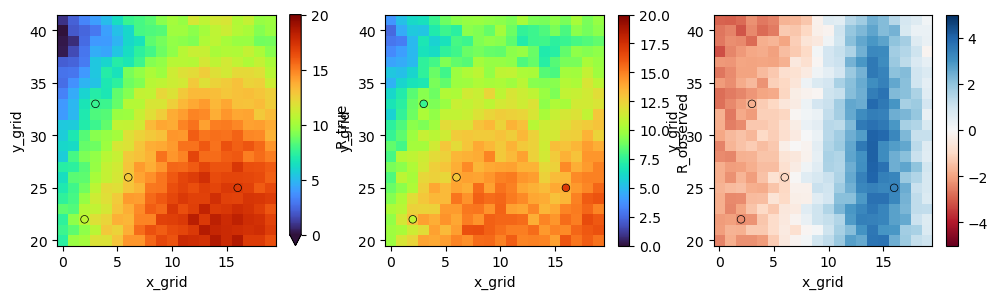

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true - ds_radar.R_observed, 
    da_gauges=ds_gauges.R_diff,
    use_lon_lat=False,
    vmin=-5,
    vmax=5,
    cmap='RdBu',
    kwargs_gauges_plot={"s": 30},
    ax=axs[2],
);

#### Spatial interpolation of differences

In [44]:
idw_interpolator = mrg.interpolate.InterpolateIDW(min_observations=2)

R_grid_idw = idw_interpolator.interpolate(
            da_grid=ds_radar.expand_dims('time'),
            da_gauge=ds_gauges.R_diff.expand_dims('time'),
            p=3,
            idw_method='standard',
        ).isel(time=0)

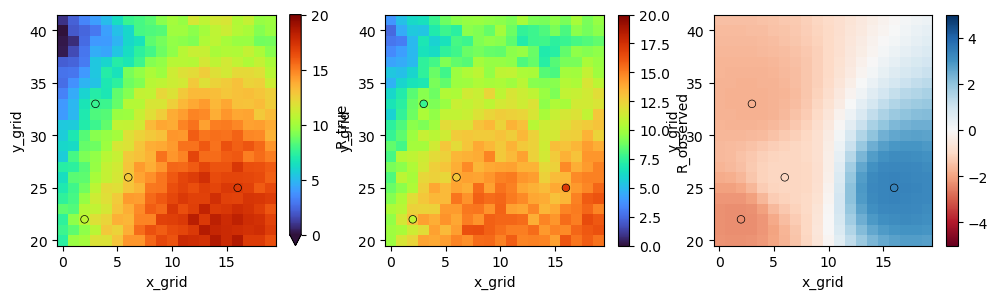

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)

plg.plot_map.plot_plg(
    da_grid=R_grid_idw, 
    da_gauges=ds_gauges.R_diff,
    use_lon_lat=False,
    vmin=-5,
    vmax=5,
    cmap='RdBu',
    kwargs_gauges_plot={"s": 30},
    ax=axs[2],
);

### Adjust radar field with interpolated diff field

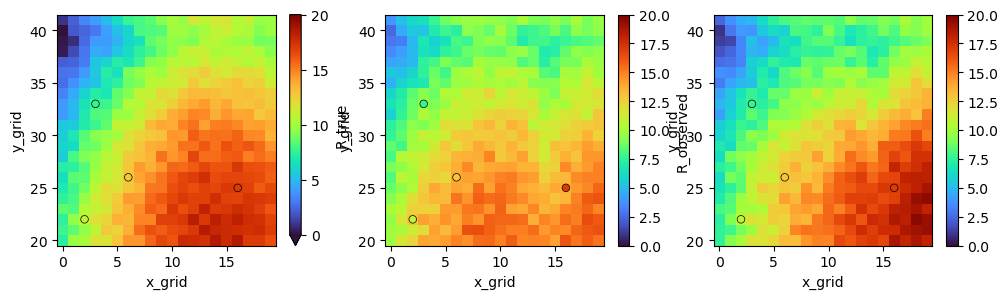

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed + R_grid_idw, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[2],
);

In [79]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data")

ds_cmls = ds_cmls.rename_vars({'R': 'R_example'})

# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, ref_str
)

ds_gauge_smhi.coords["x"], ds_gauge_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauge_smhi.lon, ds_gauge_smhi.lat, ref_str
    )
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2


# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)



File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [81]:
# Get min/max bounds
offset = 4000 # meter
x_min = ds_gauges_municp.x.min() - offset
x_max = ds_gauges_municp.x.max() + offset
y_min = ds_gauges_municp.y.min() - offset
y_max = ds_gauges_municp.y.max() + offset

# Select small area radar
ds_rad_small = ds_rad.isel(
    x = np.where((ds_rad.x_grid < x_max).any(dim='y') & (ds_rad.x_grid > x_min).any(dim='y'))[0],
    y = np.where((ds_rad.y_grid < y_max).any(dim='x') & (ds_rad.y_grid > y_min).any(dim='x'))[0],
)

# Select small area CML
ds_cmls_small = ds_cmls.isel(cml_id = np.where(
        (ds_cmls.site_0_x < x_max) & (ds_cmls.site_1_x < x_max) & 
        (ds_cmls.site_0_x > x_min) & (ds_cmls.site_1_x > x_min) & 
        (ds_cmls.site_0_y < y_max) & (ds_cmls.site_1_y < y_max) & 
        (ds_cmls.site_0_y > y_min) & (ds_cmls.site_1_y > y_min)
    )[0]
)

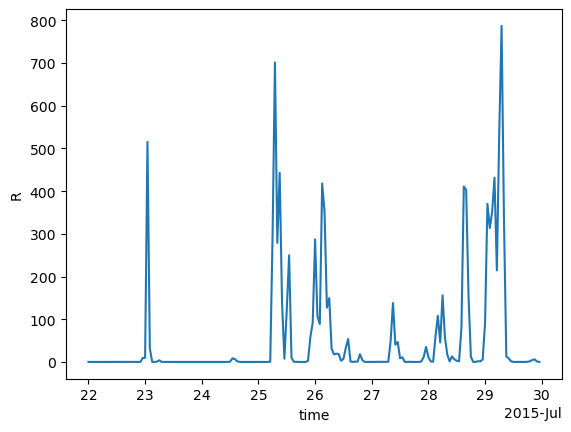

In [82]:
R_rad_1h = ds_rad_small.R.resample(time='1h').mean()
R_rad_1h.sum(dim=['x', 'y']).plot()


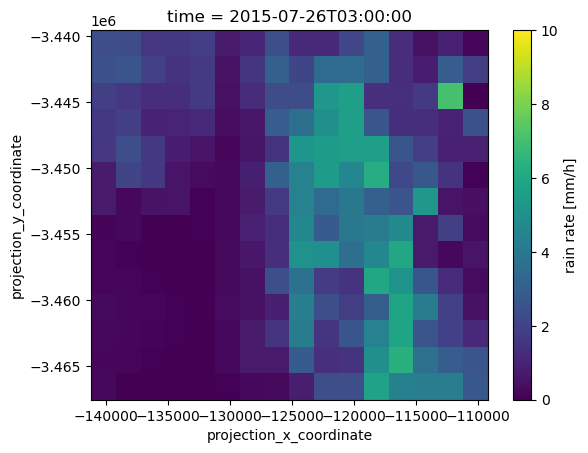

In [83]:
t= '2015-07-26 03:00:00'
R_rad_1h.sel(time=t).plot(vmin=0, vmax=10)

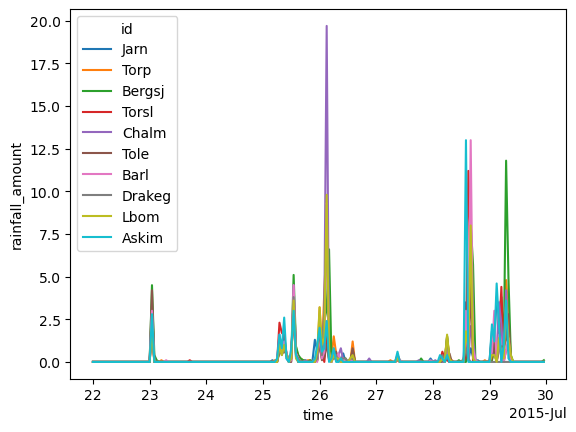

In [86]:
R_gauges_1h = ds_gauges_municp.rainfall_amount.resample(time='1h').sum()
R_gauges_1h.plot.line(x='time');

(np.float64(657419.7641765462), np.float64(691161.0882478998))

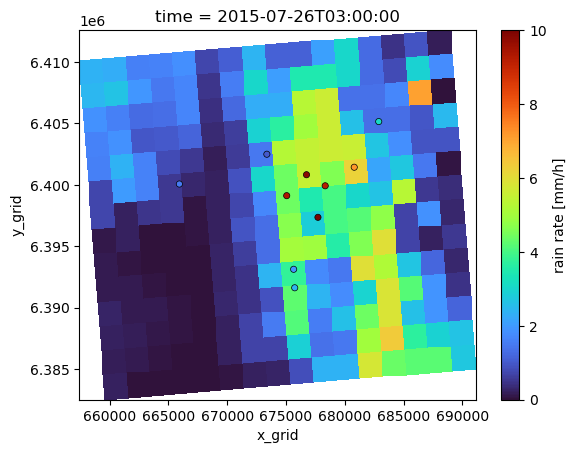

In [87]:
t= '2015-07-26 03:00:00'

plg.plot_map.plot_plg(
    da_grid=R_rad_1h.sel(time=t),
    da_gauges=R_gauges_1h.sel(time=t),
    use_lon_lat=False,
    vmin=0,
    vmax=10,
)
plt.xlim()

In [88]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges_municp,
    nnear=1,
    use_lon_lat=True,
)

ds_gauges_municp['R_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad.R,
    da_point_data=ds_gauges_municp.rainfall_amount,
)

In [96]:
#R_rad_1h.sel(time=t).coords
#R_gauges_1h.sel(time=t)


In [90]:
idw_interpolator = mrg.interpolate.InterpolateIDW()

R_grid_idw = idw_interpolator.interpolate(
            da_grid=R_rad_1h.sel(time=[t]),
            da_gauge=R_gauges_1h.sel(time=[t]),
        ).isel(time=0)

(np.float64(657419.7641765462), np.float64(691161.0882478998))

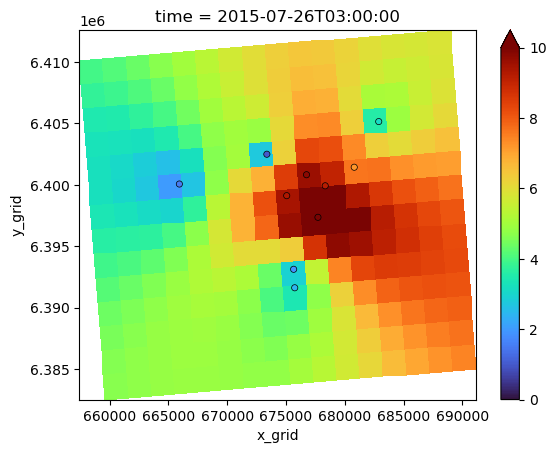

In [97]:
t= '2015-07-26 03:00:00'

plg.plot_map.plot_plg(
    da_grid=R_grid_idw,
    da_gauges=R_gauges_1h.sel(time=t),
    use_lon_lat=False,
    vmin=0,
    vmax=10,
)
plt.xlim()